In [ ]:
!pip install "sb3_contrib>=2.0.0a1" --upgrade
!pip install "stable_baselines3>=2.0.0a1" --upgrade
!pip install pvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 69.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 56.1 MB/s eta 0:00:00


## Download the folder "BEAR" and upload it to your Drive in "My Drive", then run the cells

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
cwd = os.getcwd()

os.chdir("gdrive/My Drive/BEAR")

Mounted at /content/gdrive


In [ ]:
from Env.build_env2  import BuildingEnvReal
from Data.MPC_Controller import MPCAgent
from Utils.bldg_utils2 import ParameterGenerator
import numpy as np
import datetime
import os
import time
from collections import deque
import matplotlib.pyplot as plt

##Test

We start by creating an environment with a OfficeSmall type building at Tucson, and setting the weather type as Hot Dry:

In [ ]:
Parameter=ParameterGenerator('OfficeSmall','Hot_Dry','Tucson',root='Data/')  #Description of ParameterGenerator in bldg_utils.py
#Create environment
env = BuildingEnvReal(Parameter)
numofhours=24
#Initialize
env.reset()
for i in range(numofhours):
    a = env.action_space.sample()#Randomly select an action
    obs, r, terminated, truncated, _ = env.step(a)#Return observation and reward
RandomController_state=env.statelist #Collect the state list 
RandomController_action=env.actionlist #Collect the action list 

###############All Zones from Ground############
CORE_ZN  [Zone index]:  0
PERIMETER_ZN_1  [Zone index]:  1
PERIMETER_ZN_2  [Zone index]:  2
PERIMETER_ZN_3  [Zone index]:  3
PERIMETER_ZN_4  [Zone index]:  4
ATTIC  [Zone index]:  5
###################################################
Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9        -0.07856952]


The state space:$$s_k=[T_1[k],T_2[k], ...,T_{M}[k],Q_p[k],T_G[k],T_{E}[k],Q_{ghi}[k]]$$

The action space:$$a_k=[Q^z_{1}[k],Q^z_{2}[k],...,Q^z_{M}[k]]$$

In [ ]:
obs_dim = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(obs_dim))
action_dim = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(action_dim))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))
print('Sample State :', RandomController_state[0])
print('Sample Action :', RandomController_action[0])

Size of State Space ->  10
Size of Action Space ->  6
Max Value of Action ->  1.0
Min Value of Action ->  -1.0
Sample State : [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9        -0.07856952]
Sample Action : [ 3202.7153    7927.4927   -6976.786       25.256351  6823.749
   236.16031 ]


###No Action

We first test the environment with no actions. Let's loop for 24 hours and plot the temperature and energy comsumption of each zones :

Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9        -0.07856952]


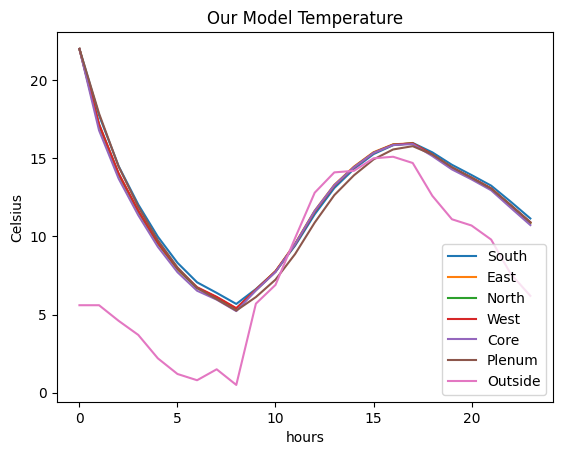

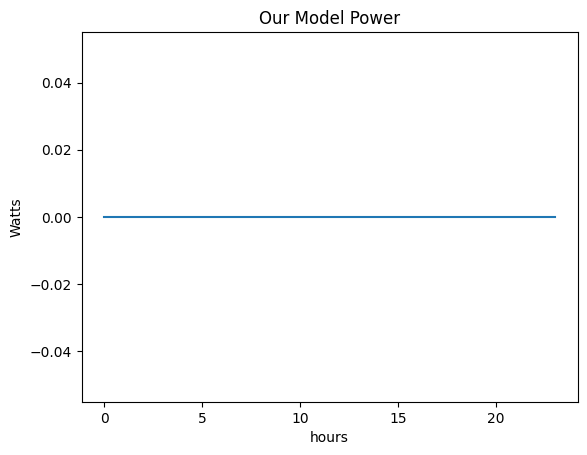

In [ ]:

numofhours=24
env.reset()
a=env.action_space.sample()
for i in range(numofhours):
    a = a*0
    obs, r, terminated, truncated, _ = env.step(a)
plt.plot(np.array(env.statelist)[:,:-3])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')

plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))

plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()

In [ ]:
print('zone temerature at 1 a.m. :', np.array(env.statelist)[1,:-4])

zone temerature at 1 a.m. : [17.75179317 17.07085633 17.14668666 17.19433022 16.78964807 17.86825243]


###MPC

Then we use a MPC controller and set each room at 22 degrees:

Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9        -0.07856952]
total reward is:  -0.19466647171187196


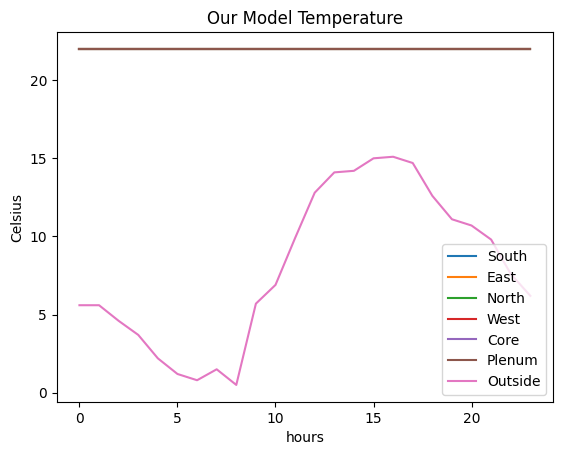

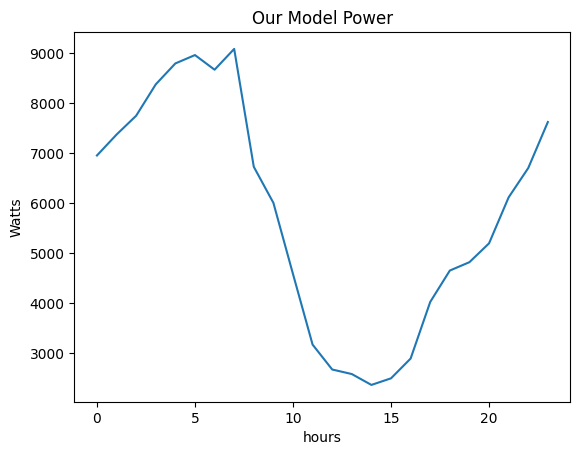

In [ ]:
agent = MPCAgent(env,
                gamma=env.gamma,
                safety_margin=0.96, planning_steps=10)
env.reset()
numofhours=24
reward_total=0
for i in range(numofhours):
    a,s = agent.predict(env)
    obs, r, terminated, truncated, _ = env.step(a)
    reward_total+=r
print('total reward is: ',reward_total)
plt.plot(np.array(env.statelist)[:,:-3])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))
plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()
MPCstate=env.statelist
MPCaction=env.actionlist

In [ ]:
print('zone temerature:', np.array(env.statelist)[0,:-4])

zone temerature: [22. 22. 22. 22. 22. 22.]


### Reinforcement Learning

Finally, we use a PPO controller to demonstrate RL usage. We perform a quick train with default settings and save the model:

In [ ]:
from stable_baselines3 import PPO ,DQN,DDPG
from stable_baselines3.common.logger import configure
from stable_baselines3.ppo import MlpPolicy
# from stable_baselines.bench import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_vec_env

In [ ]:

seed=25
env.reset()
set_random_seed(seed=seed)
model = PPO(MlpPolicy, env, verbose=1)
rewardlist=[]

for i in range(300):  
  model.learn(total_timesteps=1000)
  rw=0
  vec_env = model.get_env()
  obs = vec_env.reset()
  for i in range(24):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    rw+=rewards
  print(rw/24)
  rewardlist.append(rw/24)
print("################TRAINING is Done############")
model.save("PPO_quick")


Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9        -0.07856952]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9        -0.07856952]
-----------------------------
| time/              |      |
|    fps             | 1092 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9        -0.07856952]
[-25.488317]
Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9        -0.07856952]
-----------------------------
| time/              |      |
|    fps             | 1169 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-------------------

Then, we load the model and see the performance of the state and action:

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9        -0.07856952]
Initial observation [[22.         22.         22.         22.         22.         22.
   5.6         0.         20.9        -0.07856952]]


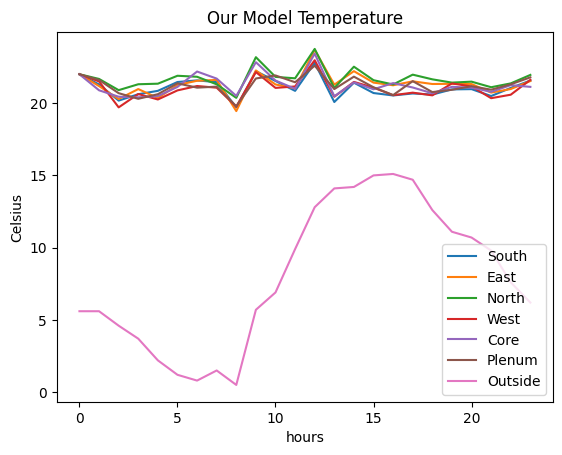

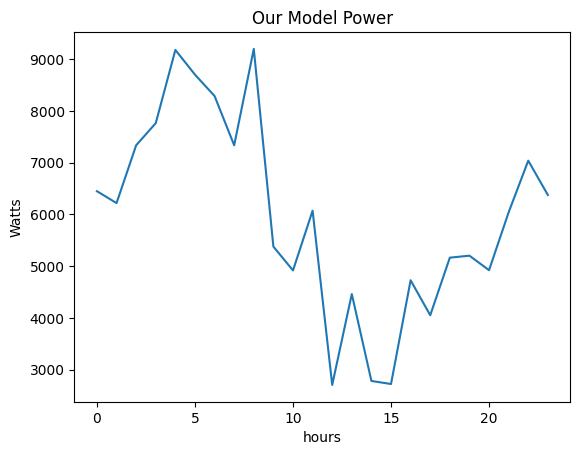

In [ ]:

model = PPO(MlpPolicy, env, verbose=1)
vec_env = model.get_env()
model = PPO.load("PPO_quick")
obs = vec_env.reset()
print("Initial observation", obs)

for i in range(24):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
plt.plot(np.array(env.statelist)[:,:-3])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))
plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()

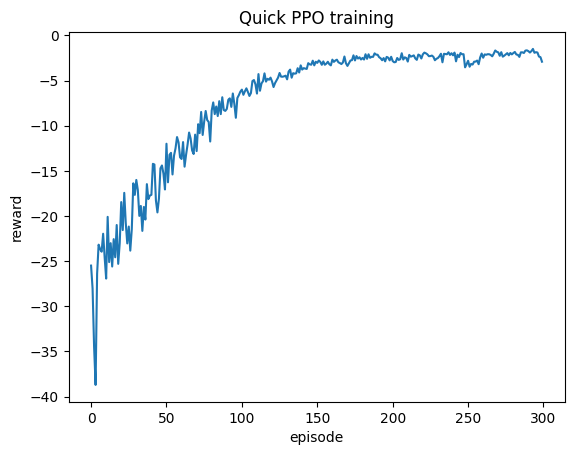

In [ ]:
plt.title('Quick PPO training')
plt.plot(rewardlist)
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

In [ ]:
env.close()